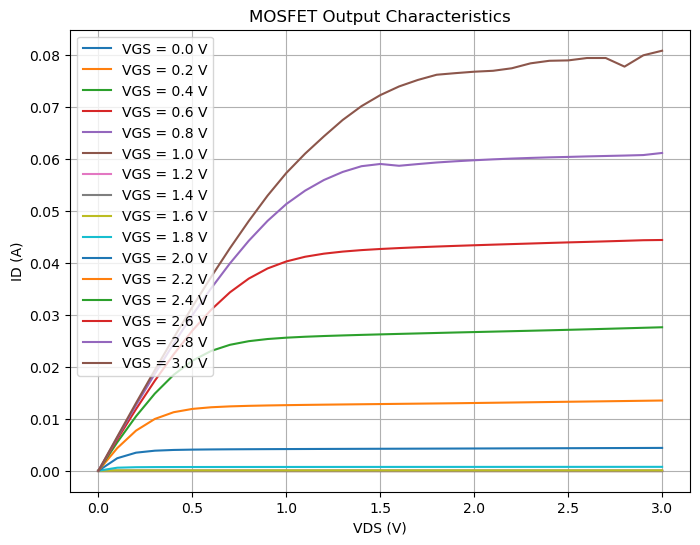

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
file_path = "Ouput 0-3V Gate 0-3V Step 0.2.txt"

# Read the file and parse the columns
data = np.loadtxt(file_path, usecols=(0, 1))

# Extract VDS and ID
VDS = data[:, 0]
ID = data[:, 1]

# Determine unique VGS values (VGS increments by 0.2V)
VGS_values = np.arange(0, 3.2, 0.2)

# Reshape data based on VGS increments
num_points_per_sweep = len(VDS) // len(VGS_values)
VDS = VDS[:num_points_per_sweep]  # Take the first sweep for VDS reference

# Reshape ID to group by VGS
ID = ID.reshape(len(VGS_values), num_points_per_sweep)

# Plot the data
plt.figure(figsize=(8, 6))
for i, VGS in enumerate(VGS_values):
    plt.plot(VDS, ID[i, :], label=f'VGS = {VGS:.1f} V')

plt.xlabel("VDS (V)")
plt.ylabel("ID (A)")
plt.title("MOSFET Output Characteristics")
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/200
25/25 [==============================] - 1s 12ms/step - loss: 0.0422 - mae: 0.1506 - val_loss: 0.0515 - val_mae: 0.1538
Epoch 2/200
25/25 [==============================] - 0s 4ms/step - loss: 0.0251 - mae: 0.1161 - val_loss: 0.0381 - val_mae: 0.1319
Epoch 3/200
25/25 [==============================] - 0s 4ms/step - loss: 0.0196 - mae: 0.1028 - val_loss: 0.0264 - val_mae: 0.1253
Epoch 4/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0149 - mae: 0.0895 - val_loss: 0.0204 - val_mae: 0.0981
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0104 - mae: 0.0685 - val_loss: 0.0152 - val_mae: 0.0867
Epoch 6/200
25/25 [==============================] - 0s 4ms/step - loss: 0.0084 - mae: 0.0657 - val_loss: 0.0117 - val_mae: 0.0676
Epoch 7/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0063 - mae: 0.0546 - val_loss: 0.0090 - val_mae: 0.0723
Epoch 8/200
25/25 [==============================] - 0s 3ms/step - loss: 0.0042 - 

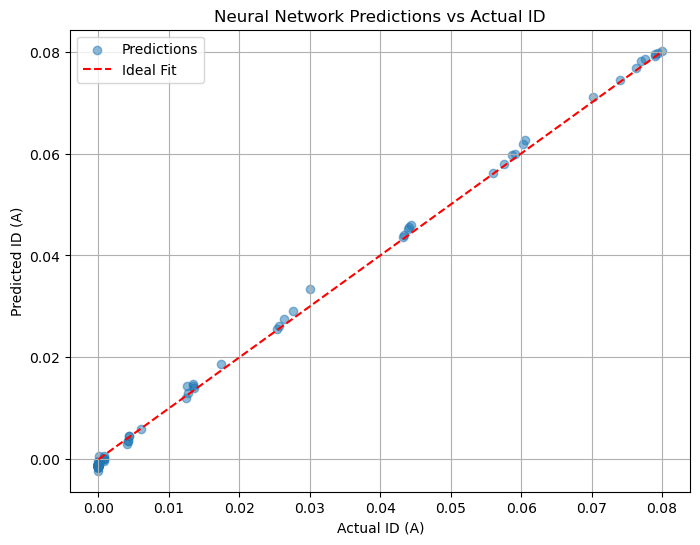

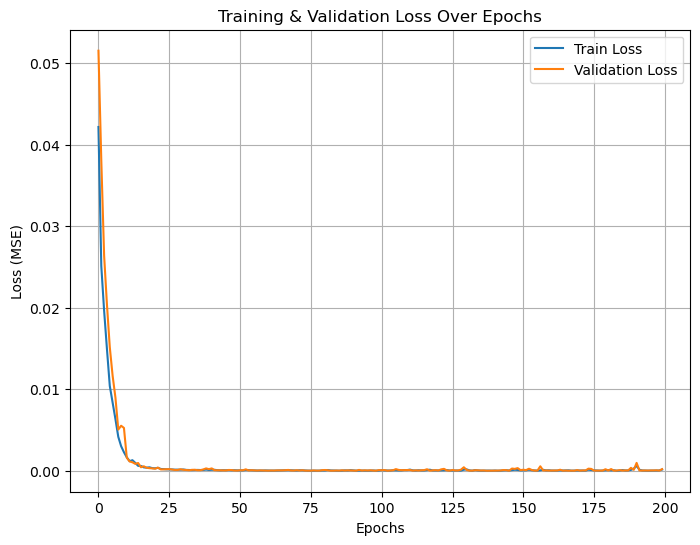

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load the data
file_path = "Ouput 0-3V Gate 0-3V Step 0.2.txt"
data = np.loadtxt(file_path, usecols=(0, 1))  # Ignore third column

# Generate VGS values
VGS_values = np.repeat(np.arange(0, 3.2, 0.2), len(data) // 16)  # 16 VGS values from 0V to 3V in steps of 0.2V

# Extract VDS and ID
VDS = data[:, 0]
ID = data[:, 1]

# Stack VGS and VDS as features
X = np.column_stack((VGS_values, VDS))
y = ID

# Normalize the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define neural network model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(2,)),  # Two input features: VGS, VDS
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1)  # Single output: ID
])

# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Evaluate model performance
loss, mae = model.evaluate(X_test, y_test)
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

# Compute additional performance metrics
mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)

# Print performance metrics
print(f"Test MAE: {mae:.6f}")
print(f"Test MSE: {mse:.6e}")
print(f"Test RMSE: {rmse:.6e}")
print(f"Test R² Score: {r2:.6f}")

# Plot Actual vs Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_actual, y_pred, alpha=0.5, label="Predictions")
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r', linestyle='dashed', label="Ideal Fit")
plt.xlabel("Actual ID (A)")
plt.ylabel("Predicted ID (A)")
plt.title("Neural Network Predictions vs Actual ID")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss Curves
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
model.save("BS170FTA.h5")  # Saves as an HDF5 file

4/4 [==============================] - 0s 2ms/step


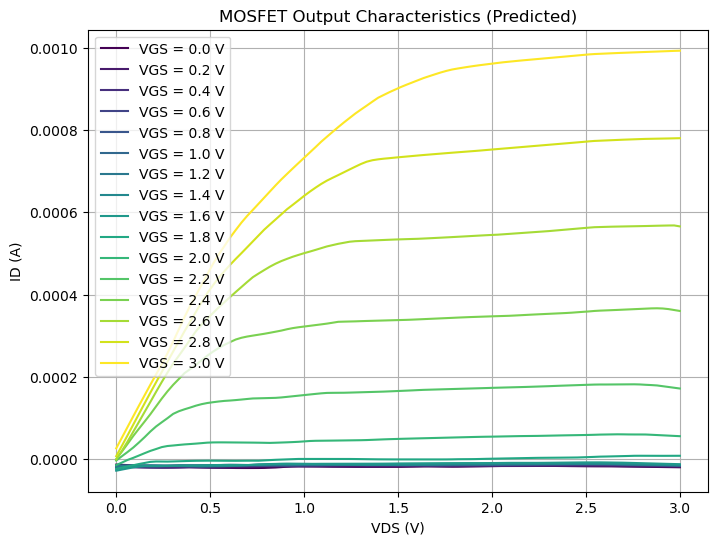

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load the saved model
model = load_model("BS170FTA.h5")

# Define VGS values for the plot
VGS_values = np.arange(0, 3.2, 0.2)  # From 0V to 3V in steps of 0.2V
VDS_values = np.linspace(0, 3, 100)  # Sweep VDS from 0V to 3V

# Initialize the MinMaxScaler (same scaling as used during training)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scalers on known training data ranges (manually set or from training data)
scaler_X.fit(np.array([[0, 0], [3, 3]]))  # VGS from 0-3V, VDS from 0-3V
scaler_y.fit(np.array([[0], [1e-3]]))  # ID range example (adjust if needed)

# Prepare and predict ID for each VGS
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(VGS_values)))  # Assign colors for different VGS

for i, VGS in enumerate(VGS_values):
    # Create input data for this VGS
    X_test = np.column_stack((np.full_like(VDS_values, VGS), VDS_values))
    
    # Scale the input data
    X_test_scaled = scaler_X.transform(X_test)
    
    # Predict ID
    ID_pred_scaled = model.predict(X_test_scaled)
    
    # Inverse transform predictions
    ID_pred = scaler_y.inverse_transform(ID_pred_scaled)
    
    # Plot
    plt.plot(VDS_values, ID_pred, color=colors[i], label=f"VGS = {VGS:.1f} V")

plt.xlabel("VDS (V)")
plt.ylabel("ID (A)")
plt.title("MOSFET Output Characteristics (Predicted)")
plt.legend()
plt.grid(True)
plt.show()
